## Compute the NGAO index for the model 
### Based on the method of Hauri et al 2021

In [1]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
from scipy import stats
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import pandas as pd
import matplotlib as mpl
from numpy import loadtxt # lecture des .txt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker
import warnings
import datetime # Python standard library datetime module
import netCDF4 as nc
import xarray as xr
from matplotlib.path import Path

import statsmodels.tsa.tsatools
from statsmodels.tsa.seasonal import seasonal_decompose
from eofs.standard import Eof

import copy
import esmpy as ESMF
import matplotlib.colors as mcolors

import pyart
import cmocean

warnings.filterwarnings('ignore')
%matplotlib inline

Could not save font_manager cache [Errno 28] No space left on device



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def convert_nep_time(time):
    ref = dt.datetime(1993,1,1,0,0,0)
    date_vals = np.zeros(len(time))
    for nt in range(len(time)):
        day_time = ref + dt.timedelta(days=float(time[nt]))
        date_vals[nt] = pltd.date2num(day_time)
            
    return date_vals

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
def plt_goa_eof(clon,clat,data):
    
    ax = fig.add_subplot(spec[neof,3*nprod:3*nprod+3], projection=ccrs.Mercator())
    C=ax.pcolormesh(clon,clat,data,vmin=diag_dict[nep_diag]['vmin'],vmax=diag_dict[nep_diag]['vmax'],
                    transform=ccrs.PlateCarree(),cmap='inferno',)
    
    ax.add_feature(cfeature.LAND,zorder=20)
    ax.coastlines('50m',linewidth=1,zorder=20)
    ax.set_extent([-163, -133,47.5,62])
    
    if neof == 0:
        ax.set_title(mod_title,fontsize=18)
        
    if nprod == 1:
        pos = ax.get_position()
        cax = fig.add_axes([pos.x0+1.02*pos.width, pos.y0+.1*pos.height, .04*pos.width, .8*pos.height])
        cbar = plt.colorbar(C,cax=cax)
        cbar.ax.locator_params(nbins=5)
        
    else: 
        ax.text(.02,.92,eof_label,transform=ax.transAxes,fontsize=16,zorder=30)
        
    
    ax.text(.02,.02,f'{100*variance_fractions[neof]:.1f}' + '%',transform=ax.transAxes,fontsize=16,zorder=50)
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)

In [5]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [6]:
# Loading grid and mask
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

#Gulf of Alaska subset
w_i = 122 
e_i = 260
n_j = 586
s_j = 455
# rho cells

nep_lsm = lsm[s_j:n_j,w_i:e_i]
nep_topo = nep_topo[s_j:n_j,w_i:e_i]
nep_clon = nep_clon[s_j:n_j+1,w_i:e_i+1]
nep_clat = nep_clat[s_j:n_j+1,w_i:e_i+1]
nep_lon = nep_lon[s_j:n_j,w_i:e_i]
nep_lat = nep_lat[s_j:n_j,w_i:e_i]

coors=np.hstack((nep_lon.reshape(-1, 1), nep_lat.reshape(-1,1)))

In [7]:
prod_dict = {'NEP':{'filname':'/work/role.medgrp/NEP/plotting/Figure_22_23/nep_ssh_1993-2019_ts.nc',
                    'varnm':'ssh','color':'darkorange','label':'NEP10k'},
             'CMEMS':{'filname':'/work/role.medgrp/NEP/plotting/Figure_22_23/CMEMS_adt_1993-2019_ts.nc',
                      'varnm':'adt','color':'navy','label':'Satellite'}}

pc_labels=['PC1 (NGAO)','PC2 (GOADI)']
r_x = .65; r_y = .9

In [8]:
coors=np.hstack((nep_lon.reshape(-1, 1), nep_lat.reshape(-1,1)))

bering_dict = {'ber': {'title':'Bering Sea',
                       'points': [(203.59,58.91),(201.31,65.44),(191,65.76),  (169.14,53.18),(173.18,52.81),
                                  (179.51,51.78),(186.81,52.16),(193.05,53.65),(199.2,55.63),(202.98,57.47),
                                  (203.59,58.91),]}
              }


poly_path=Path(np.array(bering_dict['ber']['points']))
poly_mask = poly_path.contains_points(coors).reshape(nep_lon.shape[0],nep_lat.shape[1])

NameError: name 'diag_dict' is not defined

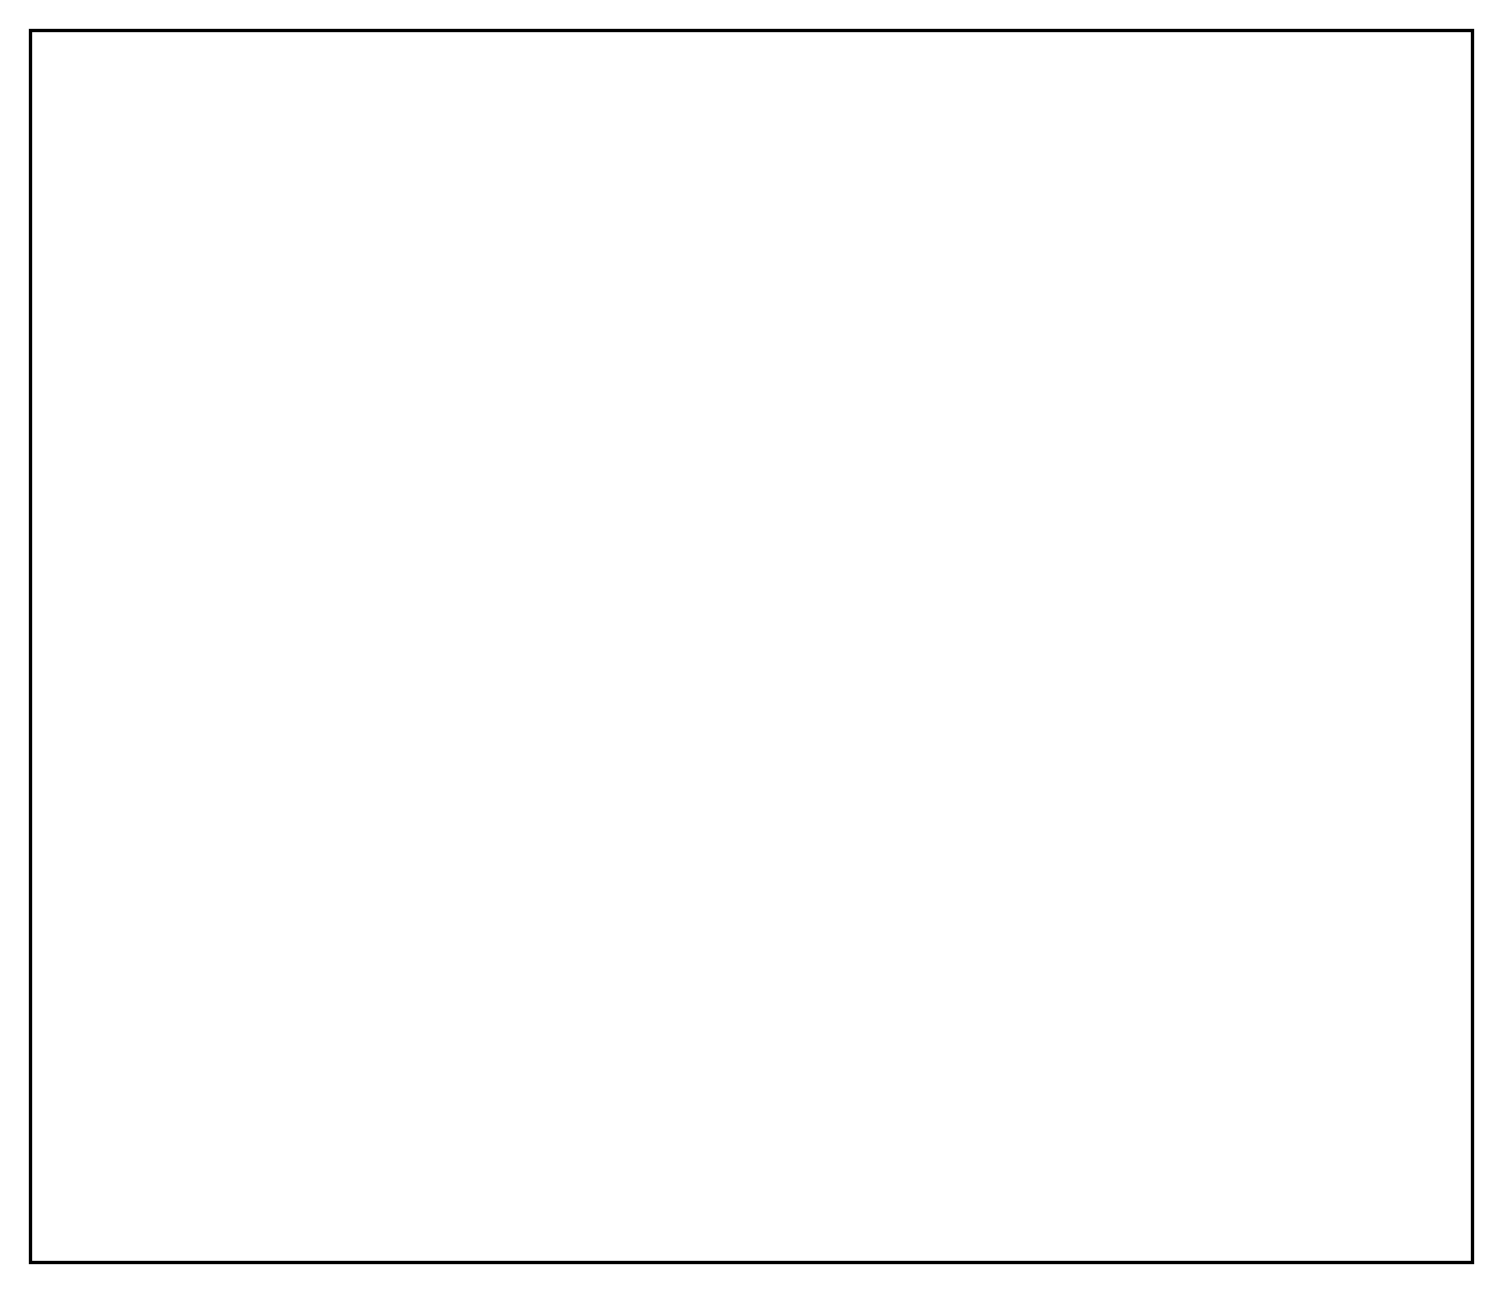

In [9]:
# Creating EOF and Timeseries Figure Object
const_offset = 2
heights = [2,2,.3,1,.1,1]
widths = [2,.5,2,2,.5,2]

nep_diag = 'SSH'
fig = plt.figure(figsize=(12.4, 18),dpi=300)
spec = fig.add_gridspec(ncols=6, nrows=6,wspace=0,hspace=0,height_ratios=heights,width_ratios=widths) 

ds = xr.open_dataset(prod_dict['NEP']['filname'],decode_times=False)
nctime = ds['time'][:]
plt_time = convert_nep_time(nctime)

# iterate over model product
for mod_prod,nprod,mod_title in zip(['CMEMS','NEP'],range(2),['Satellite SSH','NEP10k SSH']):
    ds = xr.open_dataset(prod_dict[mod_prod]['filname'],decode_times=False)
    
    if mod_prod == 'NEP':
        nctime = ds['time'][:]
        plt_time = convert_nep_time(nctime)
        nbday = len(plt_time)
        nul=np.zeros(nbday)
        clon = nep_clon   
        clat = nep_clat
        zos=np.array(ds[prod_dict[mod_prod]['varnm']][:,s_j:n_j,w_i:e_i])
         
        # coordinate specifics
        lsm_out = nep_lsm
        poly_mask = poly_path.contains_points(coors).reshape(nep_lon.shape[0],nep_lat.shape[1])
        
    else:
        zos=np.array(ds[prod_dict[mod_prod]['varnm']][:])
        
        # coordinate specifics
        lon = ds.longitude.values
        lat = ds.latitude.values
                    
        # REGULARLY SPACED LAT/LON, can extrapolate outer corner bounds
        clon = (lon[:-1] + lon[1:])/2
        clat = (lat[:-1] + lat[1:])/2            
        clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
        clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])

        lons,lats = np.meshgrid(lon,lat)

        # ESMF regridding
        sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,nep_lsm,clon,clat)
        
        sourcefield.data[...] = nep_lsm + const_offset
        destfield = regrid(sourcefield, destfield)
        tmp_val = copy.deepcopy(destfield.data)
        tmp_val[tmp_val==0] = np.nan
        lsm_out = tmp_val - const_offset
        lsm_out[lsm_out>.5]=1
        lsm_out[lsm_out<.5]=0
        
        obs_coors=np.hstack((lons.reshape(-1, 1), lats.reshape(-1,1)))
        poly_mask = poly_path.contains_points(obs_coors).reshape(lats.shape[0],lons.shape[1])
        
        nbday = len(plt_time)
        nul=np.zeros(nbday)
        
    lsm_out[poly_mask] = 0    
    zos[:,lsm_out == 0]=np.nan
    zos[:,poly_mask]=np.nan
    
    ds.close()
    
    # Step 1: remove the quadratic trend
    zos_dtrend_quad=np.zeros(zos.shape)
    for j in range(zos.shape[1]):

        for i in range(zos.shape[2]):
            if lsm_out[j,i] == 1:
                zos_dtrend_quad[:,j,i]=statsmodels.tsa.tsatools.detrend(zos[:,j,i],order=2)
                
    zos_dtrend_quad[zos_dtrend_quad[:]>1e6]=0

    # Step 2: remove the season
    zos_dtrend_quad_seasonal=np.zeros(zos.shape)
    for j in range (zos.shape[1]):
        for i in range(zos.shape[2]):
            if lsm_out[j,i] == 1:
                tmp=seasonal_decompose(np.nan_to_num(zos_dtrend_quad[:,j,i]),model='additive',period=12)
                zos_dtrend_quad_seasonal[:,j,i]=tmp.seasonal
                
    zos_dtrend_quad_seasonal[zos_dtrend_quad_seasonal[:]<-1e6]=np.nan
    zos_dtrend_quad_deseasonal=zos_dtrend_quad[:]-zos_dtrend_quad_seasonal[:]
    zos_dtrend_quad_deseasonal[zos_dtrend_quad_deseasonal[:]==0]=np.nan
    
    # Step 3: EOF
    solver = Eof(zos_dtrend_quad_deseasonal[:])
    pcs_zeta = solver.pcs(npcs=5, pcscaling=1)
    eof = solver.eofs(neofs=5, eofscaling=2)   
    
    variance_fractions = solver.varianceFraction(neigs=5)
    eigenvalues = solver.eigenvalues(neigs=5)
    sum_eigenvalues=np.sum(eigenvalues)

    for neof,eof_label in zip(range(2),['EOF1','EOF2']):
        k = 1 # addressing arbitrary sign difference
        if (mod_prod == 'NEP') and (neof == 0):
            k = -1
        plt_goa_eof(clon,clat,k*eof[neof,:]) 
    
    # iterate over the PC
    for npc in range(2):
        k = 1 # addressing arbitrary sign difference
        if (mod_prod == 'NEP') and (npc == 0):
            k = -1
        # plot the monthly time series
        if mod_prod == 'CMEMS':
           
            ax1 = fig.add_subplot(spec[2*npc+3,:-2])
            ax2 = fig.add_subplot(spec[2*npc+3,-1])
            
            pc_store = pcs_zeta
            ax1.text(.02,.88,pc_labels[npc],transform=ax1.transAxes,fontsize=12)
            
        else:
            ax1 = fig.axes[2*npc+2]
            ax2 = fig.axes[2*npc+3]
            
            corr1 = stats.pearsonr(pcs_zeta[:,npc],pc_store[:,npc])
            print('CORRELATION:', corr1)    
            ax1.text(.88,r_y,('R = ' + f'{k*corr1[0]:.2f}'),transform=ax1.transAxes,fontsize=12)
            
            corr2 = stats.pearsonr(running_mean(pcs_zeta[:,npc],6*12),running_mean(pc_store[:,npc],6*12))
            print('CORRELATION:', corr2) 
            ax2.text(.6,r_y,('R = ' + f'{k*corr2[0]:.2f}'),transform=ax2.transAxes,fontsize=12)
        
        ax1.plot(plt_time,k*pcs_zeta[:,npc],prod_dict[mod_prod]['color'],label=prod_dict[mod_prod]['label'])
        ax1.plot(plt_time,nul,'k')
        
        # plot the running mean
        ax2.plot(running_mean(plt_time,6*12),k*running_mean(pcs_zeta[:,npc],6*12),
                         prod_dict[mod_prod]['color'],label=prod_dict[mod_prod]['label'])
        ax2.plot(plt_time,nul,'k')
        
    if mod_prod == 'CMEMS':
        eof_cmems = eof
        clon_stor = clon
        clat_stor = clat
        
    fig.axes[2].sharex(ax1)
    ax1.xaxis_date()
    ax1.set_xlim(plt_time[0],plt_time[-1])
    ax1.xaxis_date()
    plt.setp(fig.axes[2].get_xticklabels(), visible=False)
    
    fig.axes[3].sharex(ax2)
    ax2.set_xlim(running_mean(plt_time,6*12)[0],running_mean(plt_time,6*12)[-1])
    ax2.set_xticks([pltd.date2num(dt.datetime(nyr,1,1)) for nyr in np.arange(1999,2017,5)])
    ax2.xaxis.set_major_formatter(pltd.DateFormatter('%Y'))
    plt.setp(fig.axes[3].get_xticklabels(), visible=False)
    
    fig.axes[2].set_title('Monthly PC Timeseries',fontsize=14)
    fig.axes[2].legend(loc='upper right', bbox_to_anchor=(0.55, 0.3),prop={'size': 12})
    fig.axes[3].set_title('6 Year Running Mean',fontsize=14)

plt.savefig('Figure22_GOA_SSH_EOF_PC_timeseries')

### Spatial Correlations of the EOFs

In [ ]:
for neof in range(2):
    sourcefield.data[...] = eof[neof,:] + const_offset
    destfield = regrid(sourcefield, destfield)
    tmp_val = copy.deepcopy(destfield.data)
    tmp_val[tmp_val==0] = np.nan
    eof_out = tmp_val - const_offset
    nan_idx = ~np.isnan(eof_out)*~np.isnan(eof_cmems[neof,:].squeeze())
    corr = stats.pearsonr(eof_out[nan_idx].ravel(), eof_cmems[neof,nan_idx].ravel())
    print(corr)

    #fig = plt.figure()
    #ax = fig.add_subplot(111,projection=ccrs.Mercator())
    #C = ax.pcolormesh(clon_stor,clat_stor,eof_out- eof_cmems[neof,:],vmin=-0.01,vmax=0.01,cmap = 'seismic',transform=ccrs.PlateCarree())
    #ax.set_extent([-163, -133,47.5,62])
    #plt.colorbar(C)



## Figure 23 GOADI Composites

In [ ]:
def plt_goa_composite(data,nplot,title,vrange):
    
    ax = fig.add_subplot(spec[ndiag,nplot], projection=ccrs.Mercator())
    C=ax.pcolormesh(nep_clon,nep_clat,data,
                    transform=ccrs.PlateCarree(),cmap=cmap,vmin=-vrange,vmax=vrange)
    ax.add_feature(cfeature.LAND,zorder=20)
    ax.add_feature(cfeature.COASTLINE,linewidth=1,zorder=20)
    ax.coastlines('50m',linewidth=1,zorder=20)
    ax.set_extent([-163, -133,53,62])
   
        
    if ndiag == 0:
        ax.set_title(title,fontsize=15)
        
    if nplot == 1:
        pos = ax.get_position()
        cax = fig.add_axes([pos.x0+1.02*pos.width, pos.y0+.1*pos.height, .04*pos.width, .8*pos.height])
        #cax.invert_yaxis()
        cbar = plt.colorbar(C,cax=cax)
        cbar.ax.locator_params(nbins=5)
        #cax.text(.02,1.05,diag_dict[nep_diag]['units'],transform=cax.transAxes,fontsize=12,zorder=50)
        
    else:
        label_text = diag_dict[nep_diag]['label'] 
        if len(diag_dict[nep_diag]['units'])>0:
            label_text = label_text + '\n (' + diag_dict[nep_diag]['units'] +')'
            
        ax.text(.8,.93,label_text,ha='center',va='top', transform=ax.transAxes,fontsize=13,zorder=50)
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)

In [ ]:
diag_dict = {'SSH':{'filename':'nep_ssh_1993-2019_ts.nc','diag_name':'ssh','vrange':.2,'label':'SSH','units':'m','k':1},
             'SST':{'filename':'nep_sst_1993-2019_monthly_ts.nc','diag_name':'tos','vrange':1,'label':'SST','units':'$\circ$C','k':1},
             'Bottom Temp':{'filename':'nep_tob_1993-2019_monthly_ts.nc','diag_name':'tob','vrange':1,'label':'Bottom Temp','units':'$\circ$C','k':1},
             'Surface Arag':{'filename':'nep_surf_omega_arag_1993-2019_monthly_ts.nc','diag_name':'omega_arag','vrange':0.1,'label':'Surface $\Omega_{arag}$','units':'','k':1}, 
             'Bottom Arag':{'filename':{'nep_btm_co3_ion_1993-2019_monthly_ts.nc','nep_btm_co3_sol_arag_1993-2019_monthly_ts.nc'},
                            'diag_name':{'btm_co3_ion','btm_co3_sol_arag'},'vrange':0.1,'label':'Bottom $\Omega_{arag}$','units':'','k':1},
             'Bottom O2':{'filename':'nep_btm_o2_1993-2019_monthly_ts.nc','diag_name':'btm_o2','vrange':20,'label':'Bottom O$_2$','units':'$\mu$mol kg$^{-1}$','k':1000000}}

diag_list = ['SSH', 'SST', 'Bottom Temp', 'Bottom Arag','Bottom O2']

cmap = cmocean.cm.balance

In [ ]:
# Creating Composite Map Figure Object
fig =plt.figure(figsize=(8, 13),dpi=300)
spec = fig.add_gridspec(ncols=2, nrows=5,wspace=0,hspace=0.)  

for nep_diag,ndiag in zip(diag_list,range(len(diag_list))):
    print(nep_diag)
    k_val = diag_dict[nep_diag]['k']
    
    if nep_diag == 'Bottom Arag':
        ncfil_co3_ion = 'nep_btm_co3_ion_1993-2019_monthly_ts.nc'
        ds_co3_ion = xr.open_dataset(ncfil_co3_ion)
        co3_ion_val = ds_co3_ion['btm_co3_ion'].isel(xh=slice(w_i,e_i),yh=slice(s_j,n_j)).values.squeeze()
        
        ncfil_co3_sol_arag ='nep_btm_co3_sol_arag_1993-2019_monthly_ts.nc'
        ds_co3_sol_arag = xr.open_dataset(ncfil_co3_sol_arag)
        co3_sol_arag_val = ds_co3_sol_arag['btm_co3_sol_arag'].isel(xh=slice(w_i,e_i),yh=slice(s_j,n_j)).values.squeeze()
        
        diag_val = k_val*(co3_ion_val/co3_sol_arag_val)
        
        
    else:
    
        ncfil = diag_dict[nep_diag]['filename']
        ds = xr.open_dataset(ncfil)
        diag_val = k_val*ds[diag_dict[nep_diag]['diag_name']].isel(xh=slice(w_i,e_i),yh=slice(s_j,n_j)).values.squeeze()
    
    # Step 1: remove the quadratic trend
    diag_dtrend_quad=np.zeros(diag_val.shape)
    for j in range(diag_val.shape[1]):
        for i in range(diag_val.shape[2]):
            if lsm[j,i] == 1:
                diag_dtrend_quad[:,j,i]=statsmodels.tsa.tsatools.detrend(diag_val[:,j,i],order=2)
    diag_dtrend_quad[diag_dtrend_quad[:]>1e6]=0
    
    # Step 2: remove the season
    diag_dtrend_quad_seasonal=np.zeros(diag_val.shape)
    for j in range (diag_val.shape[1]):
        for i in range(diag_val.shape[2]):
            if lsm[j,i] == 1:
                tmp=seasonal_decompose(np.nan_to_num(diag_dtrend_quad[:,j,i]),model='additive',period=12)
                diag_dtrend_quad_seasonal[:,j,i]=tmp.seasonal
    
    diag_dtrend_quad_seasonal[diag_dtrend_quad_seasonal[:]<-1e6]=np.nan
    diag_dtrend_quad_deseasonal=diag_dtrend_quad[:]-diag_dtrend_quad_seasonal[:]
    diag_dtrend_quad_deseasonal[diag_dtrend_quad_deseasonal[:]==0]=np.nan
    diag_dtrend_quad_deseasonal[:,poly_mask]=np.nan
    
    if nep_diag == 'SSH':
        nbday = diag_val.shape[0]
        
        # Step 3: EOF
        solver = Eof(diag_dtrend_quad_deseasonal[:])
        pcs_zeta = solver.pcs(npcs=5, pcscaling=1)
        eof = solver.eofs(neofs=5, eofscaling=2)
        variance_fractions = solver.varianceFraction(neigs=5)
    
        eigenvalues = solver.eigenvalues(neigs=5)
        sum_eigenvalues=np.sum(eigenvalues)
        variance_fractions = solver.varianceFraction()
    
    pos=np.zeros(nbday)
    neg=np.zeros(nbday)
    pos[pcs_zeta[:,1]>=1]=1
    neg[pcs_zeta[:,1]<=-1]=1

    diag_pos = diag_dtrend_quad_deseasonal[pos.astype(bool),:]
    diag_neg = diag_dtrend_quad_deseasonal[neg.astype(bool),:]
    
    # t-test for significance
    diag_pos_sig_stor = np.nan*np.zeros(diag_val.shape[1:])
    diag_neg_sig_stor = np.nan*np.zeros(diag_val.shape[1:])
    
    for nj in range(diag_val.shape[1]):
        for ni in range(diag_val.shape[2]):
            if (~np.isnan(diag_dtrend_quad_deseasonal[0,nj,ni])) & (lsm[nj,ni] == 1):
                stats_vals_neg = stats.ttest_1samp(diag_neg[:,nj,ni], popmean=0)
                
                if stats_vals_neg[1]<.05:
                    diag_neg_sig_stor[nj,ni] = np.mean(diag_neg[:,nj,ni],axis=0) 
            
                stats_vals_pos = stats.ttest_1samp(diag_pos[:,nj,ni], popmean=0)
                if stats_vals_pos[1]<.05:
                    diag_pos_sig_stor[nj,ni] = np.mean(diag_pos[:,nj,ni],axis=0)
                    
    # generate composite plots                
    plt_goa_composite(diag_neg_sig_stor,0,'- GOADI',diag_dict[nep_diag]['vrange'])
    plt_goa_composite(diag_pos_sig_stor,1,'+ GOADI',diag_dict[nep_diag]['vrange'])
        
plt.savefig('Figure23_GOA_GOADI_composites')    